<a href="https://colab.research.google.com/github/abhinav-exp/Forecasting-CryptoCurrency-Prices/blob/master/TFLANN_with_JAYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
GitHubDataLink = 'https://raw.githubusercontent.com/abhinav-exp/Forecasting-CryptoCurrency-Prices/master/Datasets/'
InputFileLink = GitHubDataLink + 'DataBTC2017.csv'
data1 = pd.read_csv(InputFileLink, header=0, index_col=0)
print(data1)

            CBBTCUSD
DATE                
2017-06-18   2515.25
2017-06-19   2596.98
2017-06-20   2725.08
2017-06-21   2643.35
2017-06-22   2679.99
...              ...
2019-08-03  10820.75
2019-08-04  10997.82
2019-08-05  11775.14
2019-08-06  11440.08
2019-08-07  12014.41

[781 rows x 1 columns]


In [4]:
data1min = data1.min()
data1max = data1.max()

normalize = lambda x: (x - data1min + 1)/(data1max - data1min + 2)
data2 = normalize(data1)
print(data2)

            CBBTCUSD
DATE                
2017-06-18  0.034073
2017-06-19  0.038680
2017-06-20  0.045901
2017-06-21  0.041294
2017-06-22  0.043360
...              ...
2019-08-03  0.502247
2019-08-04  0.512228
2019-08-05  0.556045
2019-08-06  0.537158
2019-08-07  0.569532

[781 rows x 1 columns]


In [5]:
def split_sequence(sequence, n_steps):
  X= list()
  for i in range(len(sequence) - n_steps):
    end_ix = i + n_steps
    seq_x= sequence.values[i:end_ix, 0]
    X.append(seq_x) 
  return pd.DataFrame(X)

data3 = split_sequence(data2, 10)
print(data3.shape)
print(data3)

(771, 10)
            0         1         2         3         4         5         6  \
0    0.034073  0.038680  0.045901  0.041294  0.043360  0.043967  0.037432   
1    0.038680  0.045901  0.041294  0.043360  0.043967  0.037432  0.033530   
2    0.045901  0.041294  0.043360  0.043967  0.037432  0.033530  0.028023   
3    0.041294  0.043360  0.043967  0.037432  0.033530  0.028023  0.037484   
4    0.043360  0.043967  0.037432  0.033530  0.028023  0.037484  0.036208   
..        ...       ...       ...       ...       ...       ...       ...   
766  0.441959  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307   
767  0.449255  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562   
768  0.447073  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501   
769  0.426045  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030   
770  0.430599  0.427984  0.432307  0.461562  0.479501  0.486030  0.502247   

            7         8         9  
0    0.033530  0.028023  0.03

In [6]:
train_x = data3.iloc[:int(0.85*len(data2)), :9]
train_y = data3.iloc[:int(0.85*len(data2)), 9:10]
test_x = data3.iloc[int(0.85*len(data2)):, :9]
test_y = data3.iloc[int(0.85*len(data2)):, 9:10]
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(663, 9)
(663, 1)
(108, 9)
(108, 1)


In [70]:
class TFLANN():
  def __init__(self, W):
    self.weight_matrix = W
  
  def func_x(self, x):
    const_x = np.ones((len(x), 1))
    orginal_x = x
    sinned_x = np.sin(np.pi*x)
    cossed_x = np.cos(np.pi*x)
    # print(const_x)
    # print(x.shape)
    # print(const_x.shape)
    functioned_x = np.hstack((x, sinned_x, cossed_x, const_x))
    return functioned_x

  def forward_propagation(self, x):
    funced_x = self.func_x(x)
    return (np.tanh(np.dot(funced_x, self.weight_matrix)) + 1)/2

In [123]:
find_mse = lambda x , y: np.mean((x - y) ** 2)

class JAYATFLANN():
  def __init__(self, p_size):
    self.p_size = p_size
    self.data = []

    for i in range(p_size):
      d = {}
      d['W'] = np.random.random((9*3 + 1, 1))
      model = TFLANN(d['W'])
      d['mse'] = find_mse(model.forward_propagation(train_x), train_y)
      self.data.append(d)

    print(sum([v['mse'][9] for v in self.data]))
    print([v['mse'][9] for v in self.data])

    self.update_best_and_worst()

  def update_best_and_worst(self):
    self.best = 0
    self.worst = 0
    for i in range(self.p_size):
      if self.data[self.best]['mse'][9] > self.data[i]['mse'][9]:
        self.best = i
      if self.data[self.worst]['mse'][9] < self.data[i]['mse'][9]:
        self.worst = i

  def next_gen(self):
    for i in range(self.p_size):
      t =  self.data[i]['W']
      t += np.random.normal(loc = 0.5, scale = 0.1, size = (9*3 + 1, 1))* (self.data[self.best]['W'] - self.data[i]['W'])
      t -= np.random.normal(loc = 0.5, scale = 0.1, size = (9*3 + 1, 1)) * (self.data[self.worst]['W'] - self.data[i]['W'])
      model = TFLANN(t)
      mse = find_mse(model.forward_propagation(train_x), train_y)
      if mse[9] < self.data[i]['mse'][9]:
        self.data[i] = {'W': t, 'mse':mse}

    self.update_best_and_worst()

  def optimise(self, gen):
    for i in range(gen):
      self.next_gen()
      print(sum([v['mse'][9] for v in self.data]))

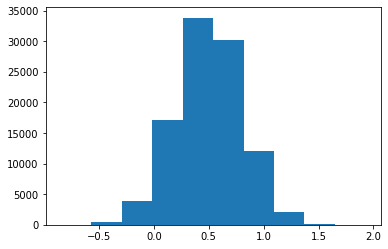

In [116]:
plt.hist(np.random.normal(loc = 0.5, scale = 0.3, size = (100000)))
plt.show()

In [124]:
optimiser = JAYATFLANN(50)
optimiser.optimise(100)
model = TFLANN(optimiser.data[optimiser.best]['W'])
preds = model.forward_propagation(test_x)
print(preds.shape)

28.626909540597524
[0.572688802852418, 0.5725546434019791, 0.5726908194867409, 0.5726954487448439, 0.5723768314496797, 0.5723507263579904, 0.5726692687822916, 0.5721926764185663, 0.5724575842193869, 0.5725852830719951, 0.5720825135184903, 0.5726651273884085, 0.5726599875299897, 0.5721920101173561, 0.572563747129819, 0.5723949133280439, 0.5726208340892656, 0.5730880769434278, 0.5726546343253831, 0.572650050957482, 0.5722169910779111, 0.5723228477672614, 0.572203452548125, 0.5726572656734744, 0.5726885816989543, 0.5726486913177938, 0.5726450339348473, 0.5726082823149836, 0.573096313424165, 0.571915746862281, 0.5719856691948939, 0.573880135563803, 0.5726487057715468, 0.5725187652389478, 0.5726717414376779, 0.5726245941519841, 0.5723818224046595, 0.5726547547539036, 0.5726679846862989, 0.5724908056609065, 0.572677867183273, 0.5722811943219036, 0.5721916940401933, 0.5726895445830832, 0.572632079627089, 0.5721044812968784, 0.5724825782245611, 0.5726481180148083, 0.5725364843083944, 0.5723033

In [126]:
preds[:, 0]

array([0.15040901, 0.15562899, 0.160923  , 0.15804703, 0.16359614,
       0.15707443, 0.15518228, 0.17721477, 0.18424688, 0.18059525,
       0.16371091, 0.17313371, 0.17010794, 0.15517811, 0.15685644,
       0.15095464, 0.14771607, 0.14883238, 0.16590615, 0.17554825,
       0.1641262 , 0.16255189, 0.18694259, 0.14409893, 0.19611007,
       0.16379982, 0.21603017, 0.19604315, 0.21013051, 0.30872336,
       0.31241705, 0.27009219, 0.25499879, 0.25375939, 0.34016925,
       0.30554109, 0.2592719 , 0.32516508, 0.29274673, 0.31754716,
       0.29697806, 0.32641072, 0.37386318, 0.32154836, 0.35729762,
       0.30235597, 0.33081147, 0.37202027, 0.33642158, 0.32263973,
       0.27200378, 0.3067861 , 0.32595253, 0.28217906, 0.30768144,
       0.27643314, 0.32504959, 0.32544395, 0.30891056, 0.35686776,
       0.34318643, 0.39655156, 0.40711823, 0.4742661 , 0.48791878,
       0.50114204, 0.60067633, 0.68611119, 0.68925696, 0.730452  ,
       0.73242774, 0.76160237, 0.67623304, 0.6820447 , 0.65066

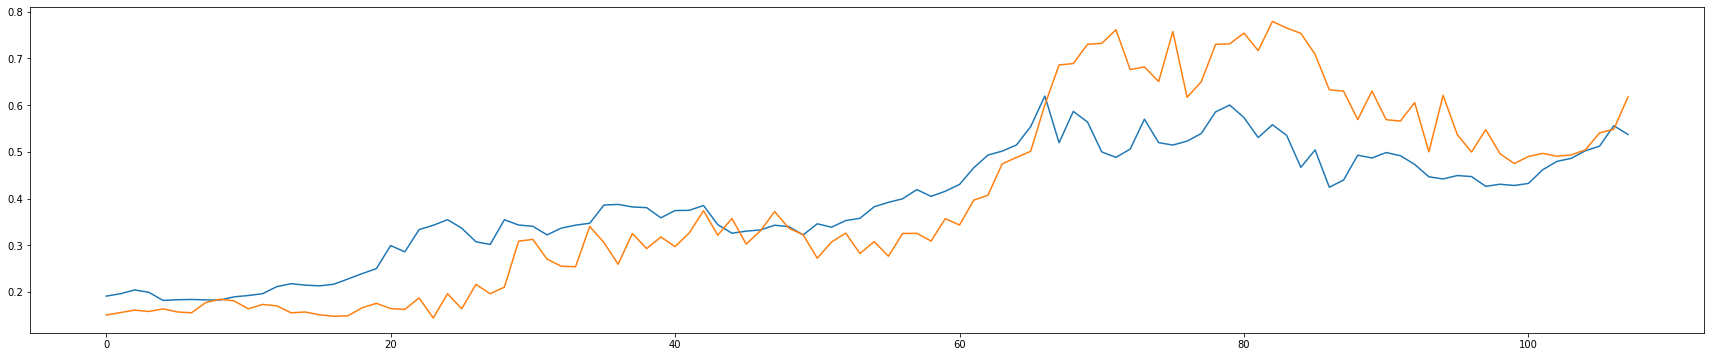

In [127]:
plt.figure(figsize=(30, 6))
plt.plot(test_y.reset_index()[9])
plt.plot(preds)
plt.show()